In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from stock import *
from sklearn.metrics import mean_absolute_error, mean_squared_error

import mplfinance as mpf

In [2]:
class StockModel(nn.Module):
    n_features = 5
    n_layers = 1
    
    def __init__(self, n_windows: int = 64, output_size: int = 8):
        super(StockModel, self).__init__()
        self.lstm = nn.LSTM(self.n_features, n_windows, self.n_layers, batch_first=True)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(n_windows, n_windows)
        self.fc2 = nn.Linear(n_windows, n_windows)
        self.fc3 = nn.Linear(n_windows, n_windows)
        self.fc4 = nn.Linear(n_windows, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

model = StockModel()
print(model)

StockModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (relu): ReLU()
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=8, bias=True)
)


In [3]:
ticker = yf.Ticker("MSFT")
raw_data = ticker.history(interval="1d", period="max")
raw_data = raw_data.reset_index()
raw_data = raw_data.drop(["Date", "Dividends", "Stock Splits"], axis=1)

data = raw_data.pct_change()
data = data.dropna()
data = data.to_numpy()

raw_data = raw_data.to_numpy()
raw_data = raw_data[1:, :]
print(raw_data.shape)
print(data.shape)

(9748, 5)
(9748, 5)


In [4]:
n_windows = 64
n_size = len(data)
n_features = len(data[0])
n_futures = 8

X = np.zeros((n_size - n_windows - n_futures, n_windows, n_features))

for i in range(n_size - n_windows - n_futures):
    X[i] = data[i:i+n_windows]
    # X.append(data[i:i+n_windows])

y = []

for i in range(n_windows, n_size - n_futures):
    t_pct = []
    for j in range(n_futures):
        pct = raw_data[i + j][3] / raw_data[i - 1][3]
        pct = pct - 1
        t_pct.append(pct)  
    y.append(t_pct)

y = np.array(y)

print(X.shape)
print(y.shape)

(9676, 64, 5)
(9676, 8)


In [5]:
dataset = StockDataset(X, y)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [7]:
n_epochs = 30

model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"EPOCH {epoch+1}/{n_epochs}: Loss - {epoch_loss/ len(train_loader):.10f}")

EPOCH 1/30: Loss - 0.0020694681
EPOCH 2/30: Loss - 0.0018015260
EPOCH 3/30: Loss - 0.0017993443
EPOCH 4/30: Loss - 0.0018011015
EPOCH 5/30: Loss - 0.0017963018
EPOCH 6/30: Loss - 0.0017972104
EPOCH 7/30: Loss - 0.0017945347
EPOCH 8/30: Loss - 0.0017979829
EPOCH 9/30: Loss - 0.0017917722
EPOCH 10/30: Loss - 0.0017936595
EPOCH 11/30: Loss - 0.0017927009
EPOCH 12/30: Loss - 0.0017892669
EPOCH 13/30: Loss - 0.0017945432
EPOCH 14/30: Loss - 0.0017981820
EPOCH 15/30: Loss - 0.0017936173
EPOCH 16/30: Loss - 0.0017905042
EPOCH 17/30: Loss - 0.0017869766
EPOCH 18/30: Loss - 0.0017897666
EPOCH 19/30: Loss - 0.0017899791
EPOCH 20/30: Loss - 0.0017776746
EPOCH 21/30: Loss - 0.0017799149
EPOCH 22/30: Loss - 0.0017680541
EPOCH 23/30: Loss - 0.0017762805
EPOCH 24/30: Loss - 0.0017717025
EPOCH 25/30: Loss - 0.0018000018
EPOCH 26/30: Loss - 0.0017927727
EPOCH 27/30: Loss - 0.0017970327
EPOCH 28/30: Loss - 0.0017973602
EPOCH 29/30: Loss - 0.0017904282
EPOCH 30/30: Loss - 0.0017915748


In [8]:
y_pred = model(torch.tensor(X[-1].reshape(1, 64, 5), dtype=torch.float32))
y_pred = y_pred.detach().numpy()
y_pred = y_pred.reshape(8,)
y_pred

array([0.00112347, 0.00362253, 0.00407371, 0.0044869 , 0.00462819,
       0.00580025, 0.00688268, 0.00878134], dtype=float32)

<Figure size 600x600 with 0 Axes>

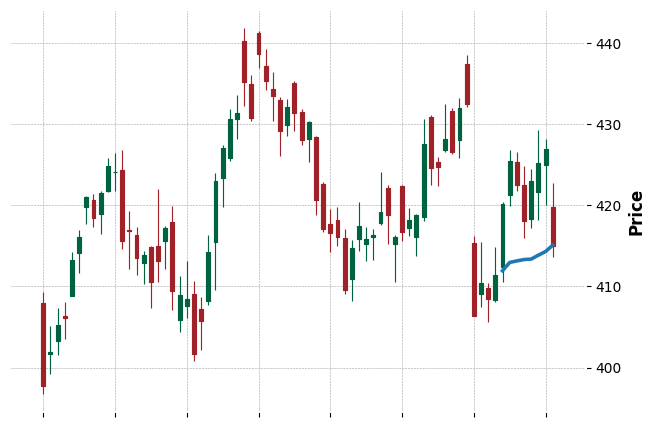

In [9]:
plot_data = raw_data[-64-8:]
df = pd.DataFrame(plot_data, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
df.index = pd.date_range("2023-01-01", periods=len(df), freq="D")

added = []
for i in range(len(df)):
    added.append(np.nan)

for i in range(8):
    added[len(df) - 8 + i] = plot_data[len(df) - 9][3] * (1 + y_pred[i])

apd = mpf.make_addplot(added)

plt.figure(figsize=(6,6))

mpf.plot(
    df,
    type='candle',
    style='charles',
    datetime_format='',
    volume=False,
    addplot=apd,
)

plt.show()